In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.set_device(0)

In [4]:
PATH = "/home/ubuntu/efs/amazon-bin/code/workspace/fastai/courses/dl1/input/"
sz = 64
arch = resnet34
bs = 128

In [5]:
label_csv = f'{PATH}counting_train_combined_csv.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
#val_idxs = get_cv_idxs(n) # random 20% data for validation set
val_idxs = np.loadtxt('/home/ubuntu/efs/amazon-bin/code/workspace/fastai/courses/dl1/input/counting_val_idxs.csv', dtype=int)
label_csv
val_idxs

array([109306, 109307, 109308, ..., 140533, 140534, 140535])

In [6]:
import numpy as np
train_idxs = np.loadtxt('/home/ubuntu/efs/amazon-bin/code/workspace/fastai/courses/dl1/input/counting_train_idxs.csv', dtype=int)


In [7]:
n

140536

In [8]:
len(val_idxs)

31230

In [9]:
print(val_idxs)

[109306 109307 109308 ..., 140533 140534 140535]


In [10]:
label_df = pd.read_csv(label_csv)

In [11]:
label_df.head()
PATH

'/home/ubuntu/efs/amazon-bin/code/workspace/fastai/courses/dl1/input/'

In [12]:
label_df.pivot_table(index="count", aggfunc=len).sort_values('idx', ascending=False)

,idx
count,
3,34985
4,31301
2,29956
5,24250
1,16201
0,3843


In [13]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv('/home/ubuntu/efs/amazon-bin/data/', 'bin-images-resize', f'{PATH}counting_train_combined_csv.csv', 
                                   val_idxs=val_idxs, tfms=tfms, bs=bs)

In [14]:
fn = '/home/ubuntu/efs/amazon-bin/data/' + data.trn_ds.fnames[0]; fn

'/home/ubuntu/efs/amazon-bin/data/bin-images-resize/131339.jpg'

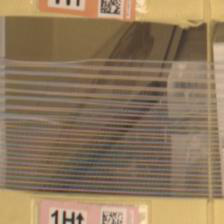

In [15]:
img = PIL.Image.open(fn); img


In [16]:
img.size

(224, 224)

In [17]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv('/home/ubuntu/efs/amazon-bin/data/', 'bin-images-resize', f'{PATH}counting_train_combined_csv.csv',
                                       val_idxs=val_idxs, tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

In [69]:
data = get_data(224, 128)

A Jupyter Widget

In [34]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [18]:
lrf=learn.lr_find()

A Jupyter Widget

 85%|████████▌ | 729/854 [01:28<00:15,  8.20it/s, loss=4.61]

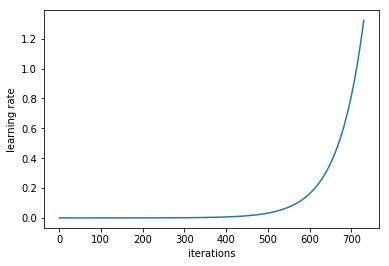

In [19]:
learn.sched.plot_lr()

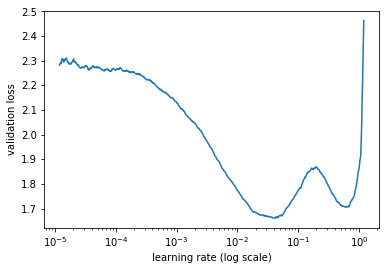

In [20]:
learn.sched.plot()

In [18]:
lr = 0.008

In [23]:
learn.fit(lr, 1)

A Jupyter Widget

  8%|▊         | 65/854 [00:08<01:39,  7.94it/s, loss=1.84] 


Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      1.511707   1.452528   0.32472   



[array([ 1.45253]), 0.32471982070432426]

In [26]:
learn.precompute=False

In [27]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      1.469381   1.436136   0.335895  
    1      1.470085   1.433655   0.332693                    
    2      1.457896   1.427818   0.338937                    
    3      1.475256   1.431611   0.335543                    
    4      1.468938   1.424193   0.3382                      
    5      1.449961   1.422112   0.338617                    
    6      1.448154   1.419217   0.342459                    



[array([ 1.41922]), 0.34245917390181474]

In [29]:
learn.save('res34_128_step1')

In [35]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [20]:
learn.load('res34_128_step1')

In [21]:
lrs = np.array([lr/9,lr/3,lr])

In [22]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      1.338355   1.314195   0.390266  
    1      1.297569   1.269096   0.408646                    
    2      1.265409   1.251534   0.423247                    
    3      1.263074   1.24049    0.4252                      
    4      1.230972   1.221713   0.436247                    
    5      1.2026     1.210508   0.443196                    
    6      1.187441   1.208664   0.444284                    



[array([ 1.20866]), 0.44428434198459221]

In [23]:
learn.save('res34_128_step2')

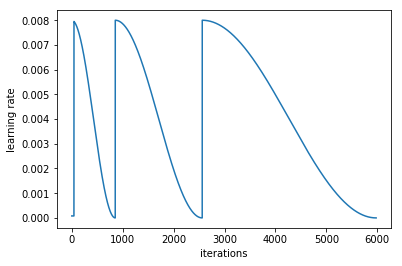

In [24]:
learn.sched.plot_lr()

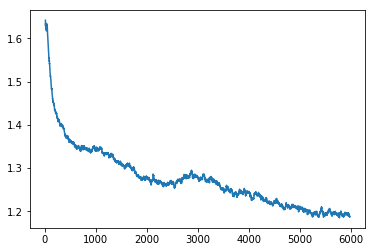

In [25]:
learn.sched.plot_loss()

In [26]:
sz=128

In [28]:
learn.set_data(get_data(sz, bs))
learn.freeze()

A Jupyter Widget

In [29]:
lrf=learn.lr_find()

A Jupyter Widget

 85%|████████▌ | 730/854 [06:29<01:06,  1.87it/s, loss=5.38]

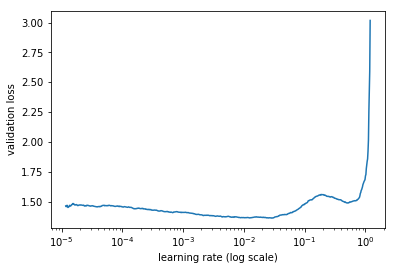

In [30]:
learn.sched.plot()

In [31]:
lr = 0.008
lr

0.008

In [32]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

  2%|▏         | 16/854 [00:08<07:40,  1.82it/s, loss=1.43] 


Exception in thread Thread-22:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      1.362791   1.347495   0.379187  
    1      1.386592   1.346254   0.376945                    
    2      1.366879   1.336519   0.3878                      
    3      1.382865   1.341509   0.379411                    
    4      1.370295   1.33698    0.382357                    
    5      1.360465   1.333504   0.385719                    
    6      1.358043   1.332103   0.389177                    



[array([ 1.3321]), 0.38917707335174062]

In [33]:
learn.unfreeze()

In [34]:
lrf=learn.lr_find()

A Jupyter Widget

 83%|████████▎ | 706/854 [09:47<02:03,  1.20it/s, loss=5.06]

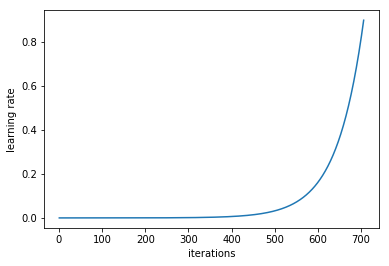

In [35]:
learn.sched.plot_lr()

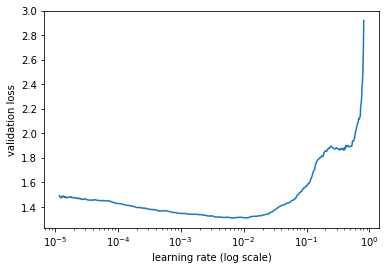

In [36]:
learn.sched.plot()

In [38]:
lrs = np.array([lr/9,lr/3,lr])

In [39]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

  0%|          | 0/854 [00:00<?, ?it/s]                     


Exception in thread Thread-37:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      1.254423   1.226549   0.441018  
    1      1.215029   1.181929   0.457733                    
    2      1.176232   1.16554    0.469709                    
    3      1.178945   1.156896   0.465482                    
    4      1.141672   1.142307   0.479571                    
    5      1.104209   1.12671    0.488889                    
    6      1.085059   1.124651   0.49065                     



[array([ 1.12465]), 0.49065001601406372]

In [40]:
learn.save('res34_128_step3')

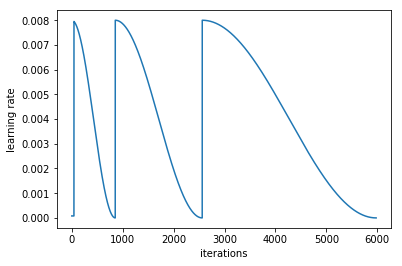

In [41]:
learn.sched.plot_lr()

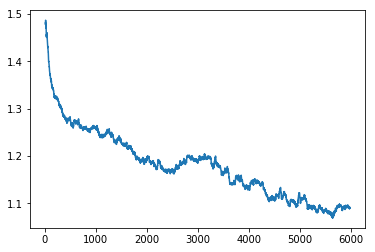

In [42]:
learn.sched.plot_loss()

In [19]:
sz=224

In [25]:
learn.set_data(get_data(sz, bs))
learn.freeze()

NameError: name 'learn' is not defined

In [45]:
lrf=learn.lr_find()

A Jupyter Widget

 85%|████████▌ | 728/854 [09:12<01:35,  1.32it/s, loss=4.52]

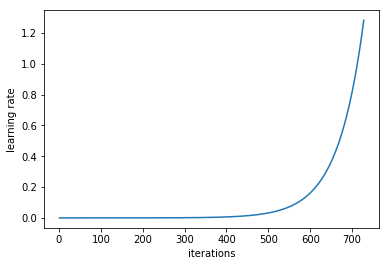

In [46]:
learn.sched.plot_lr()

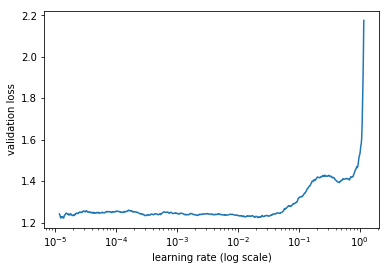

In [47]:
learn.sched.plot()

In [48]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

  0%|          | 0/854 [00:00<?, ?it/s]                     


Exception in thread Thread-53:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      1.202951   1.188218   0.462376  
    1      1.210151   1.184403   0.464585                    
    2      1.19697    1.181323   0.464233                    
    3      1.206591   1.181771   0.463913                    
    4      1.196541   1.17826    0.467147                    
    5      1.182523   1.175724   0.468716                    
    6      1.200987   1.174652   0.470157                    



[array([ 1.17465]), 0.47015690040863212]

In [49]:
learn.save('res34_128_step4')

In [36]:
learn.load('res34_128_step4')

In [37]:
learn.unfreeze()

In [38]:
lrf=learn.lr_find()

A Jupyter Widget

 84%|████████▍ | 719/854 [15:37<02:56,  1.30s/it, loss=4.59]

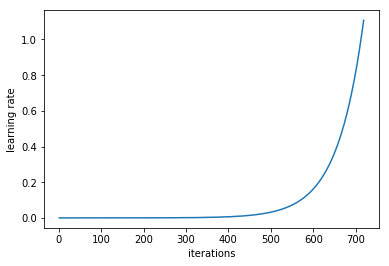

In [39]:
learn.sched.plot_lr()

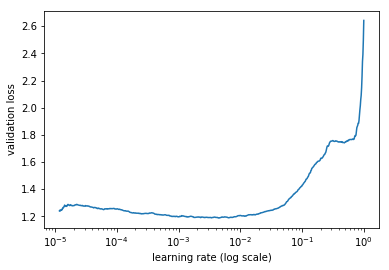

In [40]:
learn.sched.plot()

In [41]:
lr = 1e-3
lrs = np.array([lr/9,lr/3,lr])
lrs

array([ 0.00011,  0.00033,  0.001  ])

In [42]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

  0%|          | 3/854 [00:07<34:42,  2.45s/it, loss=1.26]  


Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      1.165663   1.155958   0.478066  
    1      1.149419   1.134662   0.490106                    
    2      1.137097   1.13125    0.492123                    
    3      1.137997   1.120634   0.495901                    
    4      1.117746   1.113521   0.49936                     
    5      1.114776   1.110763   0.500608                    
    6      1.102964   1.112099   0.499488                    



[array([ 1.1121]), 0.49948767222466472]

In [43]:
learn.save('res34_128_step5')

In [44]:
lrf=learn.lr_find()

A Jupyter Widget

 83%|████████▎ | 709/854 [15:28<03:09,  1.31s/it, loss=4.02]

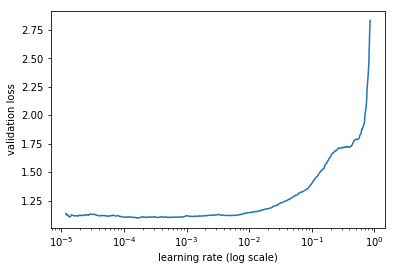

In [45]:
learn.sched.plot()

In [46]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

  0%|          | 4/854 [00:08<29:05,  2.05s/it, loss=1.12]  


Exception in thread Thread-26:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      1.106776   1.106633   0.501153  
    1      1.09314    1.10235    0.502626                    
    2      1.087049   1.102067   0.504611                    
    3      1.089909   1.098216   0.506788                    
    4      1.101569   1.094144   0.507397                    
    5      1.075541   1.092871   0.506756                    
    6      1.074767   1.092634   0.507717                    



[array([ 1.09263]), 0.50771693894773806]

In [47]:
learn.save('resnet34-128-51')

In [49]:
log_preds,y = learn.predict_with_targs()

In [51]:
preds = np.argmax(log_preds, axis=1)

In [52]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [20]:
learn = ConvLearner.pretrained(arch, data, precompute=False)


[[ 874   32    1    0    0    0]
 [  40 2899  582   94   15   11]
 [   3  790 3917 1541  322   62]
 [   1  215 1908 3720 1664  404]
 [   1   74  744 2257 2565 1208]
 [   0   56  316 1196 1837 1881]]


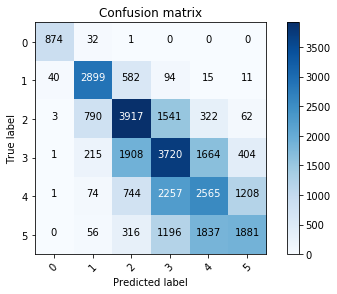

In [53]:

plot_confusion_matrix(cm, data.classes)

In [54]:
def get_data2(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv('/home/ubuntu/efs/amazon-bin/data/', 'bin-images-resize', f'{PATH}counting_train_combined_csv.csv',
                                       val_idxs=train_idxs, tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time


In [56]:
data2 = get_data2(224, 128)

A Jupyter Widget

In [57]:
learn.set_data(get_data2(224, 128))

A Jupyter Widget

In [58]:
log_preds,y = learn.predict_with_targs()

In [59]:
preds = np.argmax(log_preds, axis=1)

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 2866    56     5     4     5     0]
 [  105 10456  1659   274    46    20]
 [   13  2624 14698  5045   784   157]
 [    2   649  6513 13423  5345  1141]
 [    1   240  2340  8093  9612  4166]
 [    1    82   973  3883  6596  7429]]


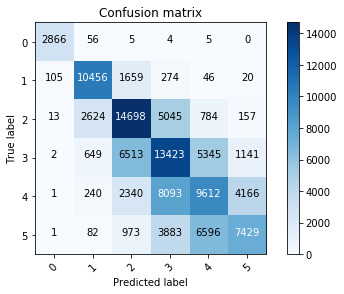

In [61]:
plot_confusion_matrix(cm, data.classes)

In [62]:
accuracy_np(preds,y)

AxisError: axis 1 is out of bounds for array of dimension 1

In [74]:
log_preds,y = learn.predict_with_targs()

In [75]:
preds = np.argmax(log_preds, axis=1)

In [76]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 874   32    1    0    0    0]
 [  40 2899  582   94   15   11]
 [   3  790 3917 1541  322   62]
 [   1  215 1908 3720 1664  404]
 [   1   74  744 2257 2565 1208]
 [   0   56  316 1196 1837 1881]]


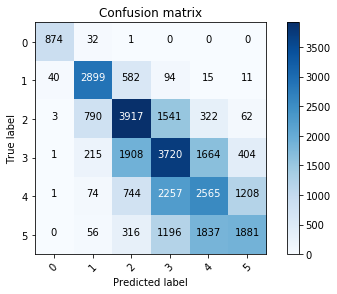

In [77]:
plot_confusion_matrix(cm, data.classes)

In [82]:
n = 0
perclass_correct = np.zeros(6) 
perclass_dist = np.zeros(6) 
perclass_N = np.zeros(6)
confusion_matrix = np.zeros((6,6), dtype=int)
for i in range(len(y)):
    pred = preds[i]
    gt = y[i]
            
    perclass_correct[gt] = perclass_correct[gt] + int(pred==gt) 
    perclass_dist[gt] = perclass_dist[gt] + np.power(pred-gt,2)
    perclass_N[gt] = perclass_N[gt] + 1
        
    confusion_matrix[gt][pred] += 1
        
    n = n+1

print('accuracy')
print('%d/%d (%f)' %(perclass_correct.sum(), perclass_N.sum(), perclass_correct.sum()/perclass_N.sum()))
print('RMSE(Root mean squared error)')
print(np.sqrt(perclass_dist.sum()/perclass_N.sum()))
print('Per class accuracy')
print(perclass_correct/perclass_N)
print('Per class RMSE')
print(np.sqrt(perclass_dist/perclass_N))
print(confusion_matrix)

accuracy
15856/31230 (0.507717)
RMSE(Root mean squared error)
0.964881255563
Per class accuracy
[ 0.96362  0.79621  0.59035  0.47017  0.37451  0.35585]
Per class RMSE
[ 0.19923  0.5996   0.79457  0.87495  1.01981  1.40003]
[[ 874   32    1    0    0    0]
 [  40 2899  582   94   15   11]
 [   3  790 3917 1541  322   62]
 [   1  215 1908 3720 1664  404]
 [   1   74  744 2257 2565 1208]
 [   0   56  316 1196 1837 1881]]


Now creating plots for validation set with tta

In [63]:
learn.set_data(get_data(224, 128))

A Jupyter Widget

In [64]:
log_preds, y = learn.TTA()

In [22]:
learn.load('res34_128_step5')
sz=224

In [25]:
learn.sched.plot_loss()

AttributeError: 'NoneType' object has no attribute 'plot_loss'

In [24]:
learn.set_data(get_data(sz, bs))



A Jupyter Widget

In [ ]:
learn.unfreeze()

In [ ]:
learn.set_data(get_data(sz, bs))
learn.unfreeze()

A Jupyter Widget

In [26]:
lrf=learn.lr_find()

A Jupyter Widget

 84%|████████▍ | 716/854 [15:25<02:58,  1.29s/it, loss=3.8]  

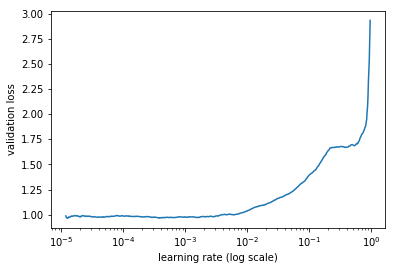

In [27]:
learn.sched.plot()

In [27]:
lr = 1e-3
lrs = np.array([lr/9,lr/3,lr])
lrs

array([ 0.00011,  0.00033,  0.001  ])

In [28]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      1.694478   1.569679   0.296061  
 19%|█▊        | 160/854 [02:00<08:42,  1.33it/s, loss=1.65]

KeyboardInterrupt: 

In [26]:
learn.save('res34_128_step6')

In [22]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [73]:
len(multi_preds)

NameError: name 'multi_preds' is not defined

In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

ValueError: Found input variables with inconsistent numbers of samples: [31230, 109306]

In [41]:
preds

array([[-14.87235, -14.73259,  -9.29616,  -1.29953,  -0.46382,  -2.97067],
       [ -8.21655,  -8.62226,  -6.60938,  -2.81801,  -0.91248,  -0.69952],
       [-12.75029,  -7.58428,  -0.05736,  -3.02397,  -5.64515,  -7.12661],
       ..., 
       [-10.50361,  -5.47712,  -1.34832,  -0.80168,  -1.86117,  -3.42072],
       [ -7.48939,  -5.34117,  -3.14502,  -1.77735,  -1.10399,  -0.82424],
       [-10.31492,  -7.69556,  -3.59953,  -1.2909 ,  -0.91535,  -1.28831]], dtype=float32)

In [1]:
# Confusion Matrix

predictions = np.argmax(preds, axis=1)


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, predictions)

plot_confusion_matrix(cm, data.classes)

NameError: name 'np' is not defined

In [25]:
print(len(y))
count = 0
for i in range(len(y)):
    if np.argmax(preds, axis=1)[i] == y[i]:
        count += 1
print(count)

31230
6068


In [ ]:
#53.8%

In [20]:
sz=224
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=False)

A Jupyter Widget

In [25]:
learn.load('res34_128_step6')
learn.unfreeze()

In [21]:
lrf=learn.lr_find()

A Jupyter Widget

 86%|████████▌ | 733/854 [10:29<01:43,  1.16it/s, loss=3.37] 

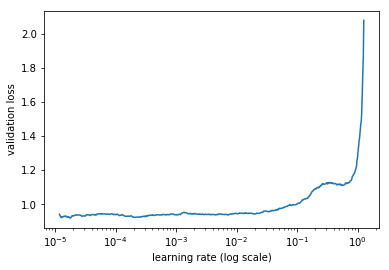

In [22]:
learn.sched.plot()

In [25]:
lr = (1e-5)*2
lr

2e-05

In [26]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

  0%|          | 1/854 [00:04<1:01:22,  4.32s/it, loss=0.826]

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.941778   1.064784   0.529011  
    1      0.936827   1.064428   0.528466                    
    2      0.934985   1.066763   0.527826                    
    3      0.939554   1.064858   0.529267                    
    4      0.946105   1.064497   0.528658                    
    5      0.945355   1.065502   0.52821                     
    6      0.945669   1.06449    0.528082                    



[array([ 1.06449]), 0.52808197256162159]